# **Tansfer Learning for Classification of Horses and Humans**

## **Abstract**

Aim of the notebook is to demonstrate the use of the transfer learning for improving the model accuracy for real-world images.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
path_inception = f"{getcwd()}/../tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"


from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

  
# Print the model summary
pre_trained_model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output



last layer output shape:  (None, 7, 7, 768)


In [16]:
# Defining a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [17]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)
x =  layers.Dropout(0.2)(x)                    
x = layers.Dense  (1, activation='sigmoid')(x)           
         

model = Model( pre_trained_model.input, x) 


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


model.summary()




Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [18]:
# Get the Horse or Human dataset
path_horse_or_human = f"{getcwd()}/../tmp2/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = f"{getcwd()}/../tmp2/validation-horse-or-human.zip"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

shutil.rmtree('/tmp')
local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [19]:

train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') 
train_humans_dir = os.path.join(train_dir, 'humans') 
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))



500
527
128
128


In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)     
   

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)



Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [21]:


callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)


Epoch 1/50
17/17 [==============================] - 31s 2s/step - loss: 0.4578 - accuracy: 0.8491 - val_loss: 0.2821 - val_accuracy: 0.8594
Epoch 2/50
17/17 [==============================] - 29s 2s/step - loss: 0.1359 - accuracy: 0.9484 - val_loss: 0.0341 - val_accuracy: 0.9883
Epoch 3/50
17/17 [==============================] - 30s 2s/step - loss: 0.0734 - accuracy: 0.9747 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 4/50
17/17 [==============================] - 30s 2s/step - loss: 0.0935 - accuracy: 0.9698 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/50
17/17 [==============================] - 30s 2s/step - loss: 0.1006 - accuracy: 0.9873 - val_loss: 0.0118 - val_accuracy: 0.9961
Epoch 6/50
17/17 [==============================] - 31s 2s/step - loss: 0.0530 - accuracy: 0.9854 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/50
17/17 [==============================] - 31s 2s/step - loss: 0.0256 - accuracy: 0.9883 - val_loss: 2.8526e-04 - val_accuracy: 1.0000
Epoch 8/50
17/17

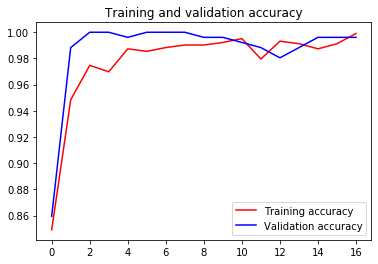

<Figure size 432x288 with 0 Axes>

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## **Refrence**

https://www.coursera.org

https://www.tensorflow.org/

Copyright 2020 Abhishek Gargha Maheshwarappa

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.